# Project 1: Hierarchical Poisson Factorization
## An overview of building recommender systems with markovian inference

In [1]:
using CSV
using DataFrames
using Plots
using Dates
using Statistics
using StatsBase
using Pipe
using SparseArrays 
using DataFramesMeta
using Gen
using Random
using LinearAlgebra

## Reproducibility

SEED = 1337

1337

## Selecting a dataset of manageable size and good quality

Selection criteria:
1. manageable size (<= 100k-150k samples)
2. big enough (>= 10k samples)
3. time ordered events
4. multiple product categories
5. numerical ratings

The following candidates were evaluated:

In [2]:
DataFrame(
    candidate=[
        "Amazon beauty", 
        "Indonesia tourism", 
        "Electronics eCommerce",
        "ModCloth ratings",
        "Amazon books"
        ],
    manageable_size=["❌", "✅", "❌", "✅", "❌"],
    big_enough=["✅", "✅", "✅", "✅", "✅"],
    time_ordered_events=["✅", "❌", "✅", "✅", "❌"],
    multiple_product_categories=["❌", "✅", "✅", "✅", "❌"],
    numerical_ratings=["✅", "✅", "❌", "✅", "❌"]
)

Row,candidate,manageable_size,big_enough,time_ordered_events,multiple_product_categories,numerical_ratings
,String,String,String,String,String,String
1,Amazon beauty,❌,✅,✅,❌,✅
2,Indonesia tourism,✅,✅,❌,✅,✅
3,Electronics eCommerce,❌,✅,✅,✅,❌
4,ModCloth ratings,✅,✅,✅,✅,✅
5,Amazon books,❌,✅,❌,❌,❌


## Exploratory data analysis of ModCloth ratings

Available at: https://www.kaggle.com/datasets/ruchi798/marketing-bias-in-product-recommendations?select=modcloth.csv

Dataset description:
* User to item ratings with scors from 1 to 5
* Events from 2010 to 2020
* Also contains category, brand, model size, user size, how the item fits
* No pricing details

Dataset cleaning:
* Keep only user - item, category, time and rating
* Discard all entries with missing values

In [3]:
# Median for datetime, taken from Reddit: 
# https://www.reddit.com/r/Julia/comments/hrfpei/defining_a_median_method_for_datetime/
Statistics.median(dateTimeArray::Array{DateTime,1}) =  DateTime(Dates.UTM(Int(round(median(Dates.value.(dateTimeArray))))))

ratings_df = CSV.read("modcloth.csv", DataFrame)

function prepare!(df)
    parse_timestamp = timestamp -> DateTime(replace(timestamp, "+00:00" => ""), "y-m-d H:M:S.s")
    ratings_df.item_id = string.(ratings_df.item_id)
    ratings_df.time = map(parse_timestamp, ratings_df.timestamp)
    ratings_df.rating_score = ratings_df.rating
    select!(ratings_df, Not([:timestamp, :brand, :year, :rating, :fit, :size, :user_attr, :model_attr, :split]))
    dropmissing!(ratings_df)
end

prepare!(ratings_df)
@assert size(ratings_df) == (99893, 5) 
summary(ratings_df)

"99893×5 DataFrame"

In [4]:
first(ratings_df, 10)

Row,item_id,user_id,category,time,rating_score
,String,String,String15,DateTime,Int64
1,7443,Alex,Dresses,2010-01-21T08:00:00,4
2,7443,carolyn.agan,Dresses,2010-01-27T08:00:00,3
3,7443,Robyn,Dresses,2010-01-29T08:00:00,4
4,7443,De,Dresses,2010-02-13T08:00:00,4
5,7443,tasha,Dresses,2010-02-18T08:00:00,4
6,7443,gina.chihos,Dresses,2010-02-25T08:00:00,5
7,7443,Kim,Dresses,2010-02-26T08:00:00,2
8,7443,jess.betcher,Dresses,2010-03-26T07:00:00,5
9,7443,Elissa,Dresses,2010-04-06T07:00:00,4


In [5]:
describe(ratings_df, :first, :eltype, :nunique, :min, :median, :max)

Row,variable,first,eltype,nunique,min,median,max
,Symbol,Any,DataType,Union…,Any,Any,Any
1,item_id,7443,String,1020,102736,,89044
2,user_id,Alex,String,44784,"""Ferrari"")",,😊
3,category,Dresses,String15,4,Bottoms,,Tops
4,time,2010-01-21T08:00:00,DateTime,14741,2010-01-21T08:00:00,2016-01-26T08:00:00,2019-06-29T13:55:16.542
5,rating_score,4,Int64,,1,5.0,5


In [6]:
# Assure that each user-item interaction is unique
@assert @pipe groupby(ratings_df, [:user_id, :item_id]) |> combine(_, nrow => :count) |> df -> maximum(df.count) == 1

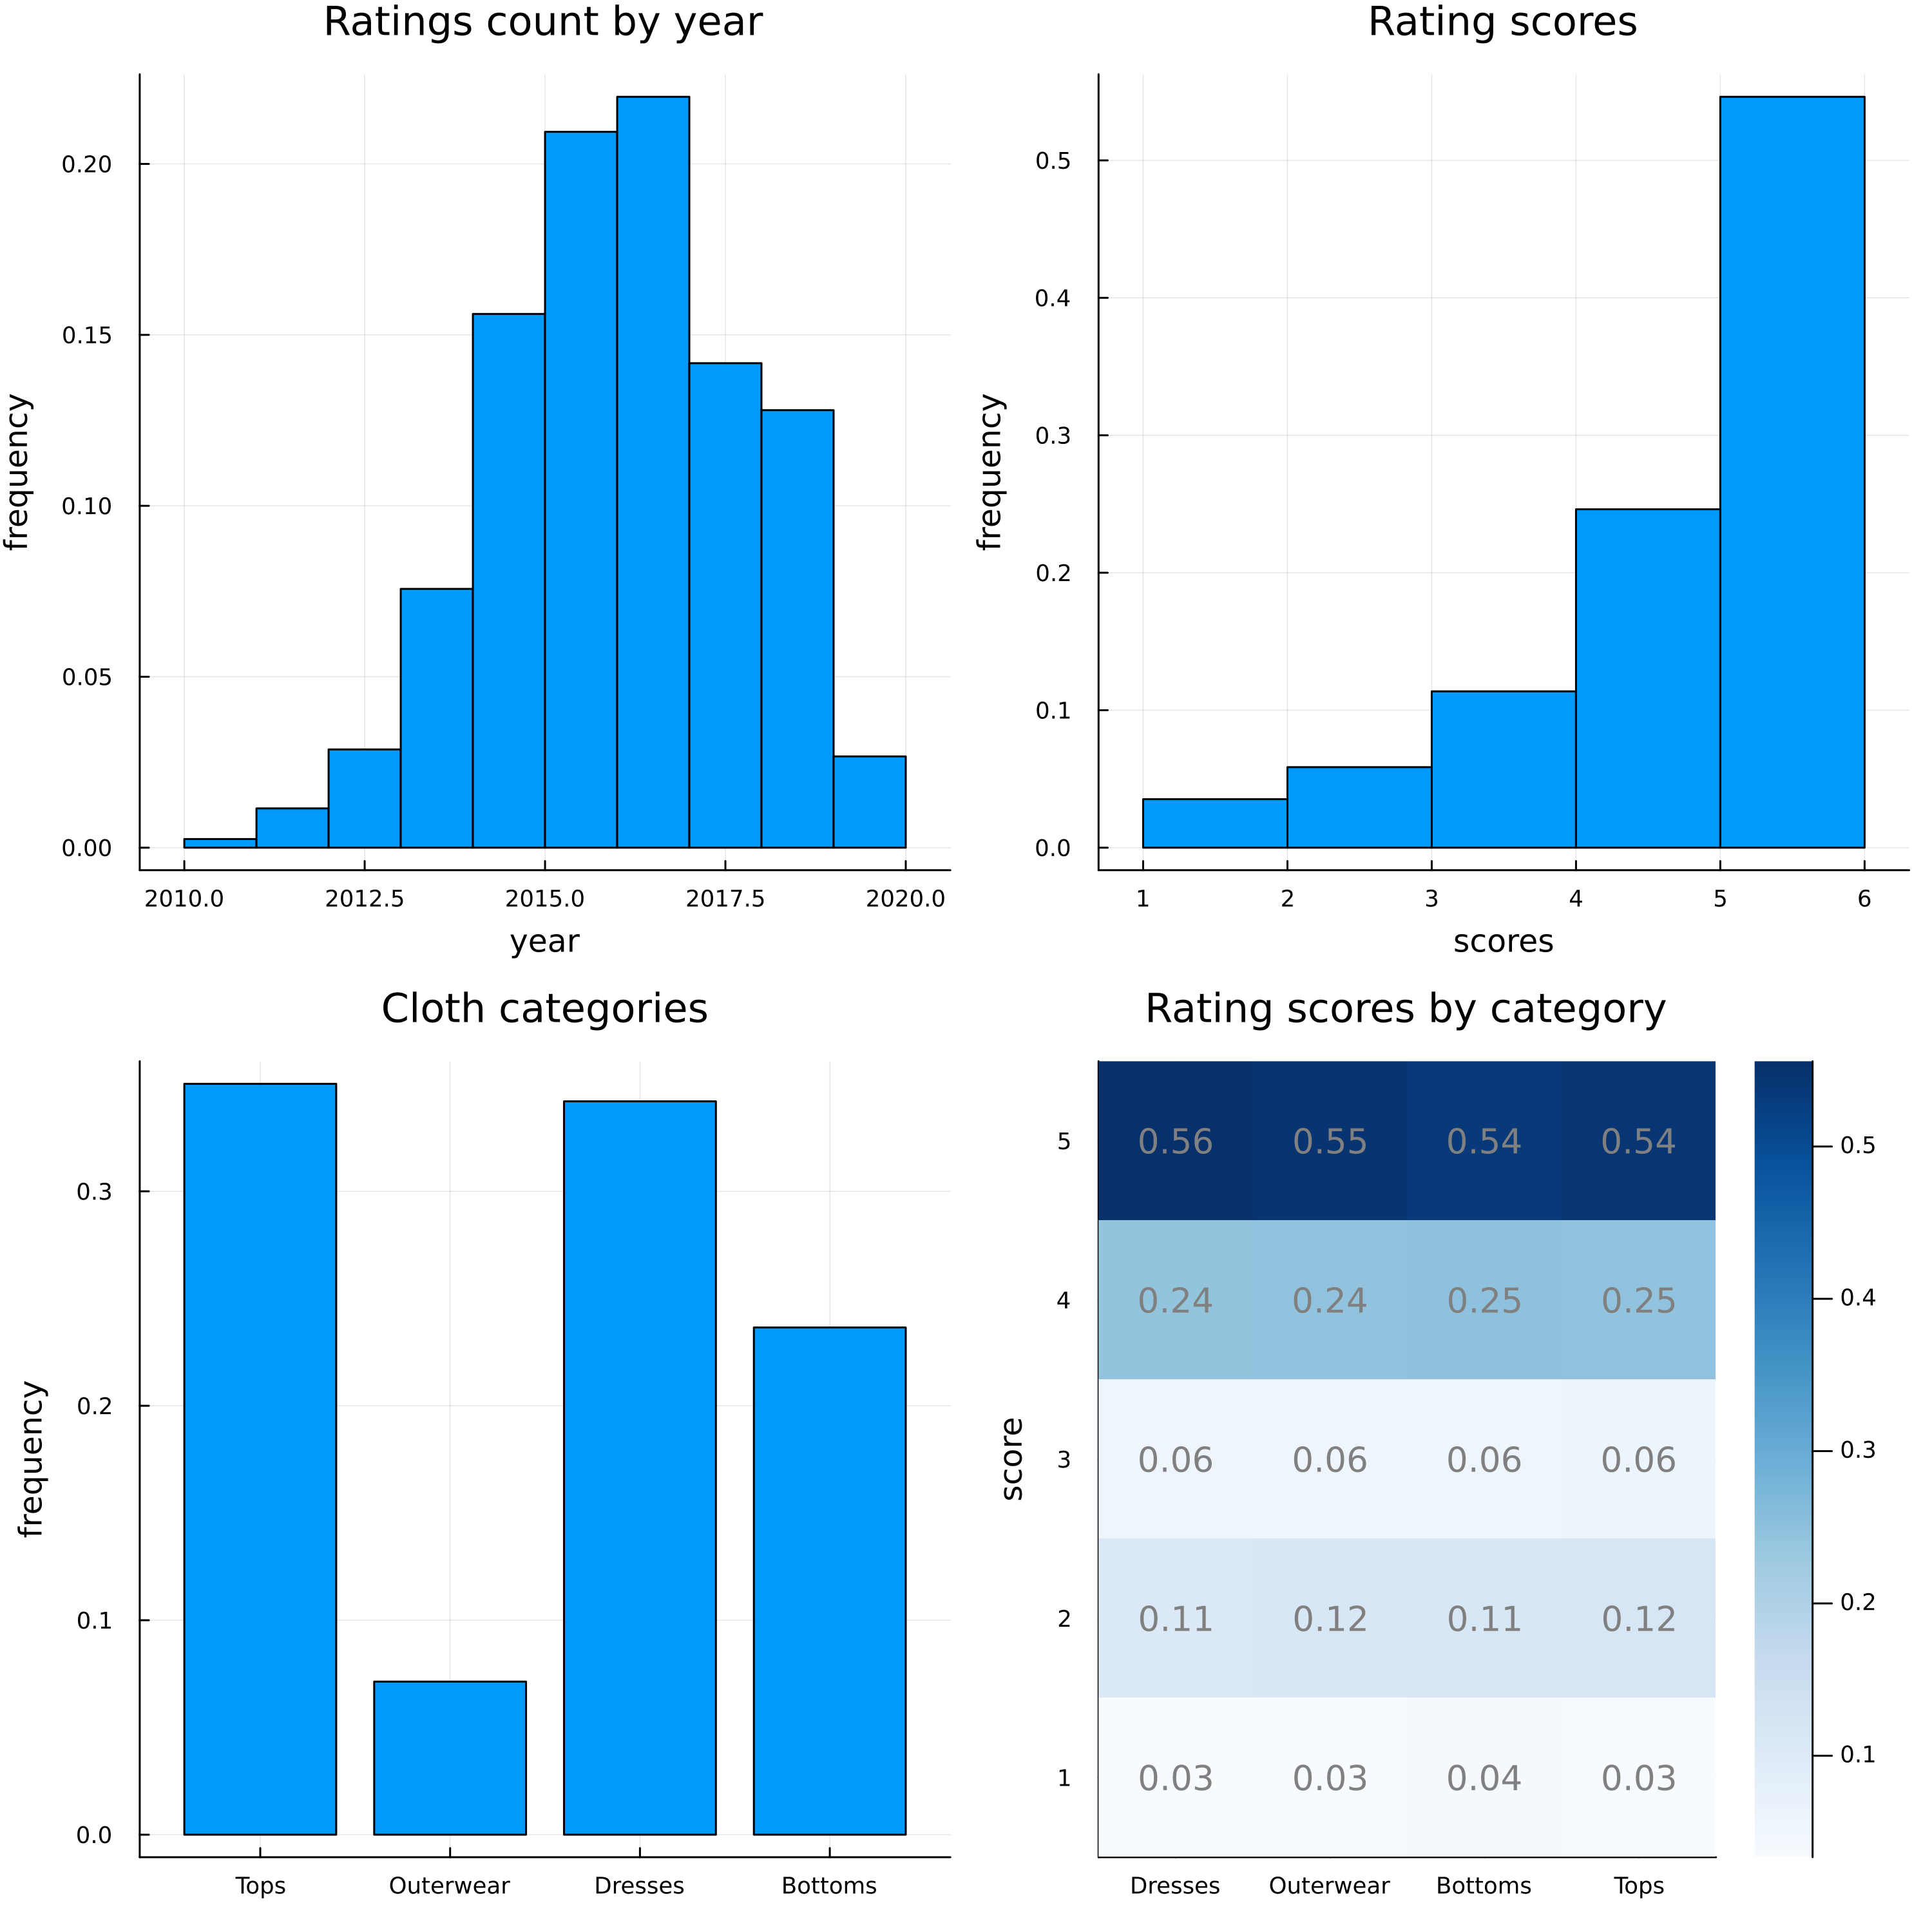

In [7]:
function make_data_distribution_plots(df)
    categories, scores_matrix = get_scores_by_category(df)
    
    plots = [
        histogram(
            map(t -> Dates.year(t), df.time), 
            title="Ratings count by year",
            label="ratings",
            xlabel="year",
            ylabel="frequency",
            bins=10, 
            normalize=true
        ),

        histogram(
            df.rating_score, 
            title="Rating scores",
            label="ratings",
            xlabel="scores",
            ylabel="frequency",
            bins=6, 
            normalize=true
        ),

        bar(
            proportionmap(df.category),
            title="Cloth categories",
            ylabel="frequency",
        ),

        heatmap(
            categories, 
            1:5, 
            scores_matrix,
            title="Rating scores by category",
            ylabel="score",
            c=:Blues,
            annotations=heatmap_annotation(scores_matrix),
        ),
    ]
    
    return plot(plots..., layout=(2,2), legend=false, size=(1000, 1000), fmt = :png, dpi=300)
end
    

function groupby_count(df, column)
    return @pipe groupby(df, column) |> 
        combine(_, nrow => :count) |> 
        sort(_, :count, rev=true)
end

function get_scores_by_category(df)
    scores_by_categ = @pipe groupby(df, :category) |> combine(_, :rating_score .=> proportionmap)
    scores_matrix = scores_by_categ.rating_score_proportionmap .|> values .|> collect .|> reverse
    scores_matrix = hcat(scores_matrix...)
        
    return scores_by_categ.category, scores_matrix
end
        
function heatmap_annotation(matrix)
    rows, columns = size(matrix)
    return [
        (j - 0.5, i, 
            text(
                round(matrix[i, j], digits=2),
                12,
                :gray,
                :center
            ), 
        ) for i in 1:rows for j in 1:columns
    ]
end

make_data_distribution_plots(ratings_df)

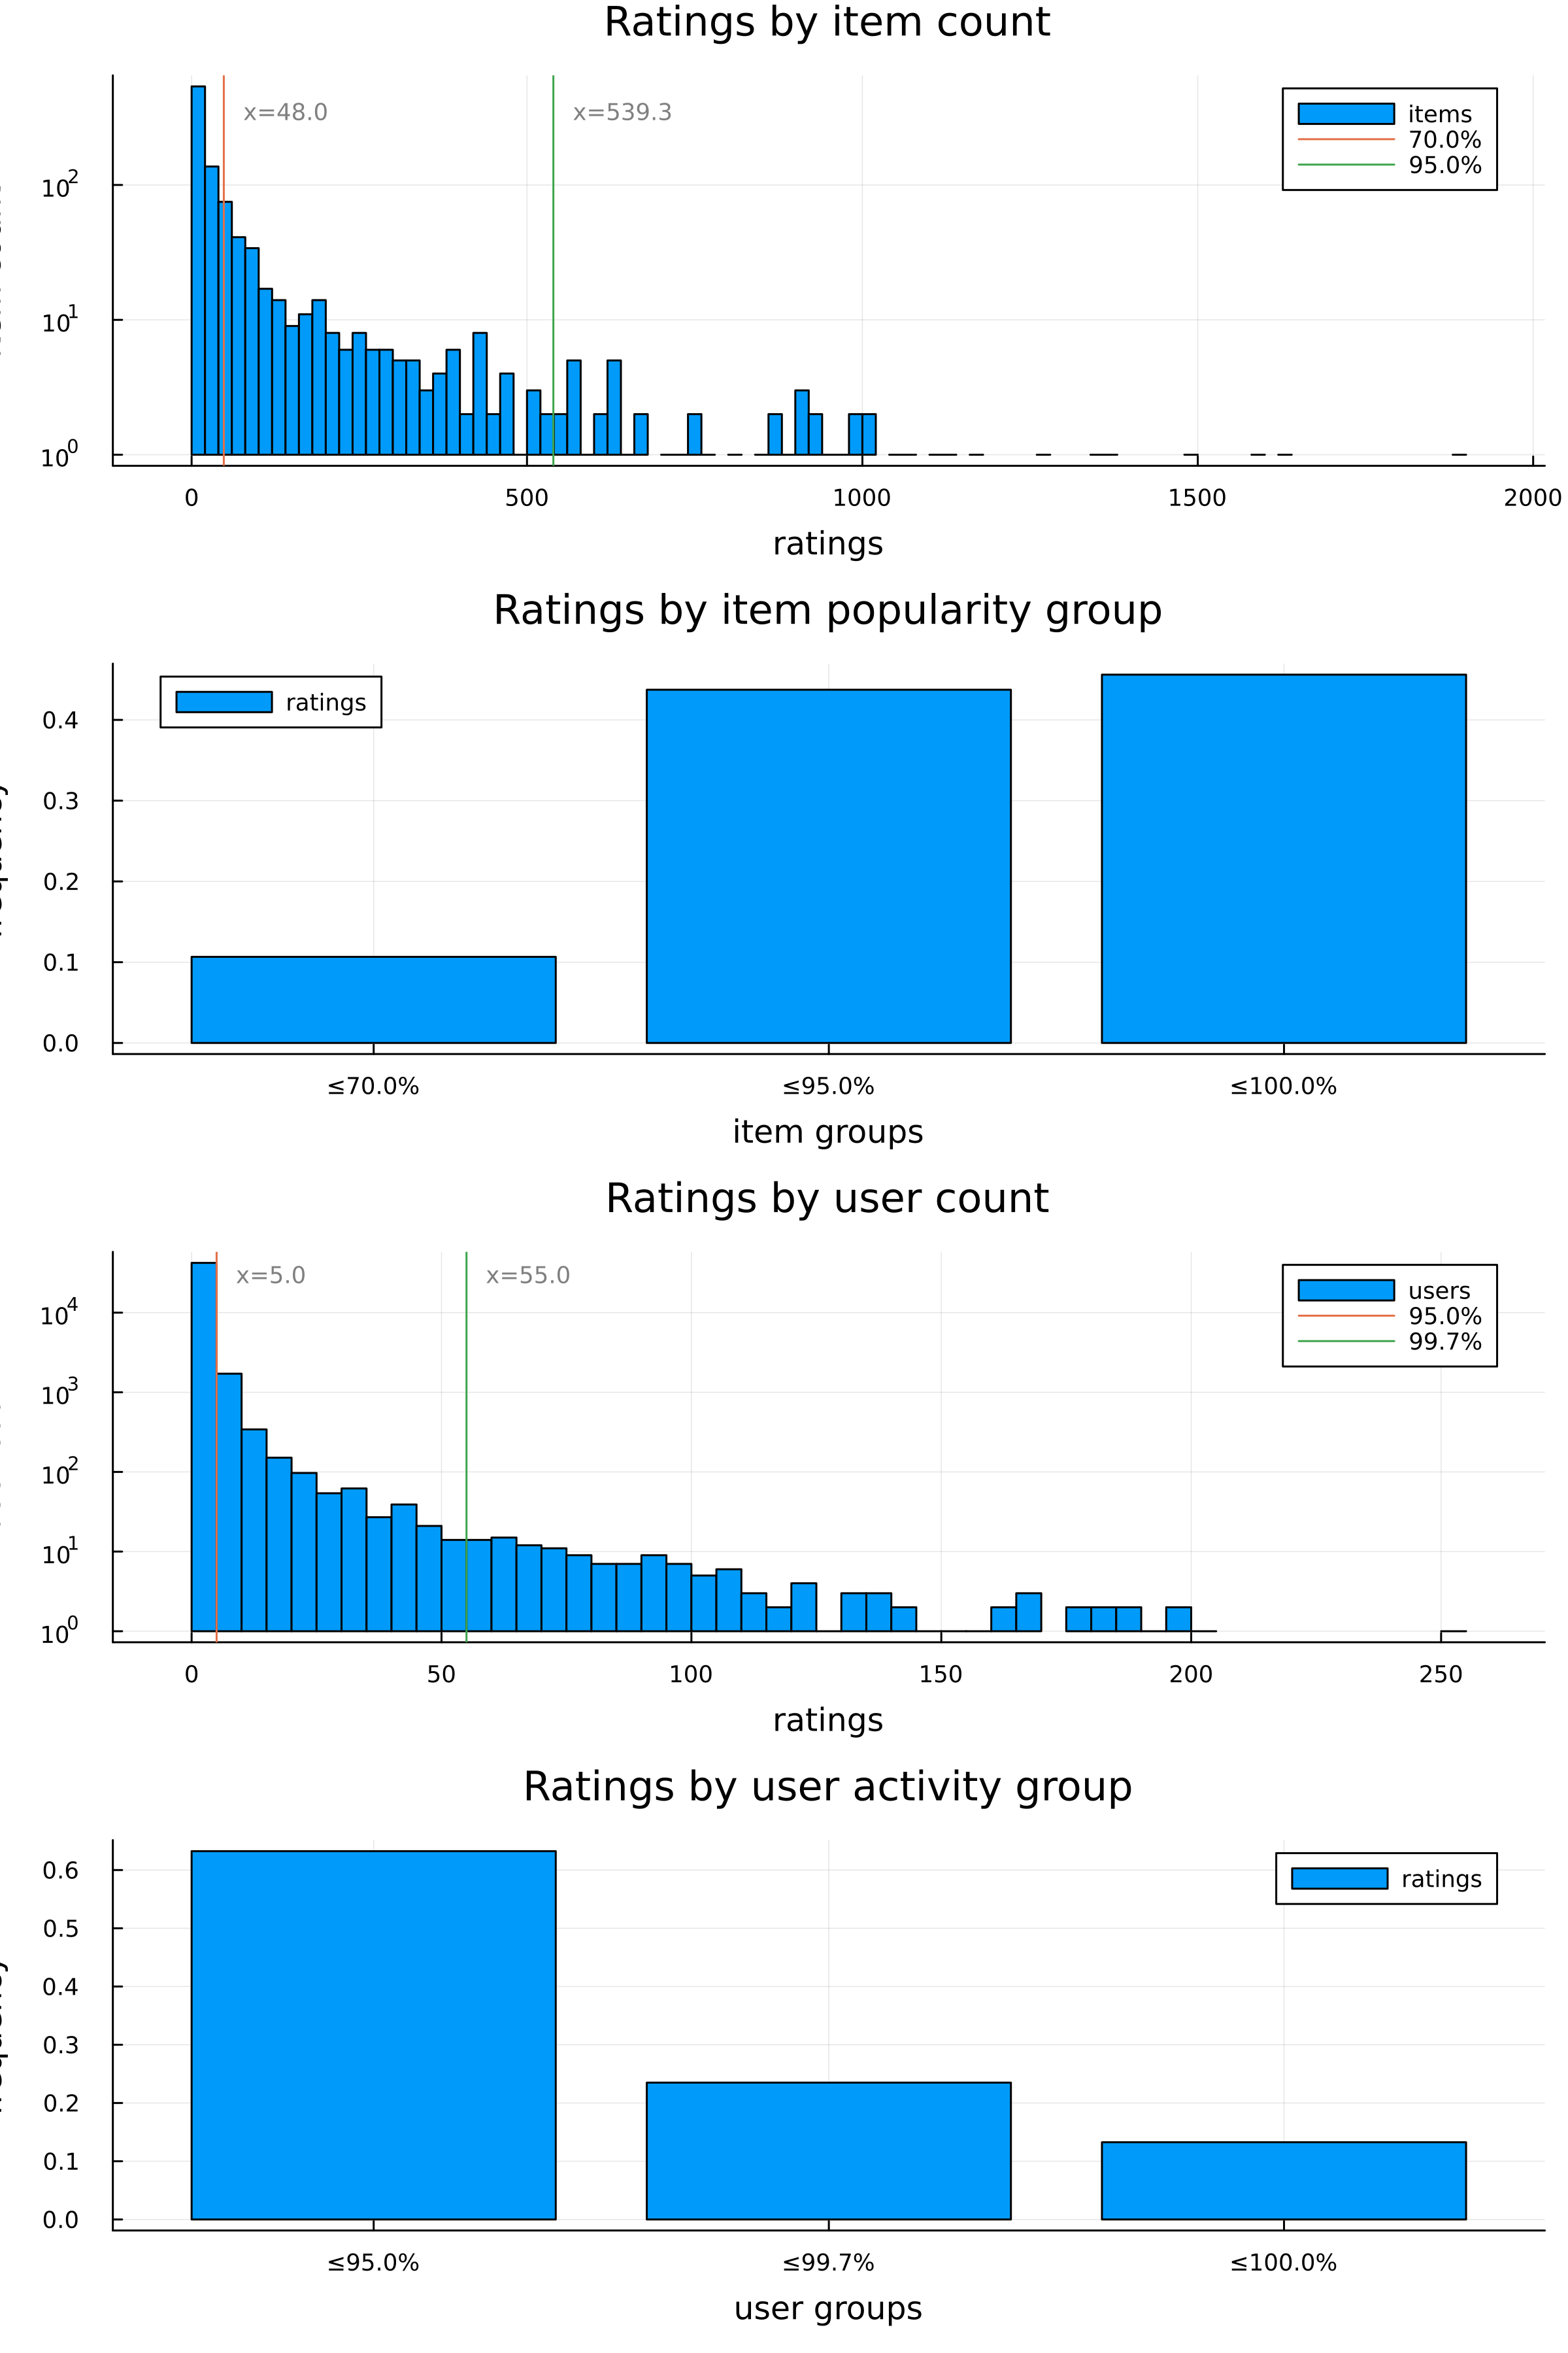

In [8]:
sum_between(df, left, right) = sum(filter(r -> left < r.count && r.count <= right, df).count)

function make_count_plots(df)
    items_quantiles = [0.70, 0.95]
    ratings_by_item = groupby_count(df, :item_id)
    ratings_by_item_hist = histogram(
            ratings_by_item.count, 
            title="Ratings by item count",
            label="items",
            xlabel="ratings",
            ylabel="item count",
            bins=100,
            yscale=:log10,
        )
    annotate_quantiles!(ratings_by_item_hist, ratings_by_item.count, items_quantiles, 30, 350)

    items_quantiles_vals = [quantile(ratings_by_item.count, q) for q in items_quantiles]
    insert!(items_quantiles_vals, 1, 0)
    push!(items_quantiles_vals,999999999999)
    quantile_sums = []
    for i in 1:length(items_quantiles_vals)-1
        push!(
            quantile_sums, 
            sum_between(ratings_by_item, items_quantiles_vals[i], items_quantiles_vals[i+1]) / size(df)[1]
        )
    end
    push!(items_quantiles, 1)
    quantile_sums_items = bar(
        ["≤"*string(round(q * 100, digits=2)) * "%" for q in items_quantiles],
        quantile_sums,
        label="ratings",
        xlabel="item groups",
        ylabel="frequency",
        title="Ratings by item popularity group",
    )
    
    users_quantiles = [0.95, 0.997]
    ratings_by_user = groupby_count(df, :user_id)
    ratings_by_user_hist = histogram(
        ratings_by_user.count, 
        title="Ratings by user count",
        label="users",
        xlabel="ratings",
        ylabel="user count",
        bins=100,
        yscale=:log10,
    )
    annotate_quantiles!(ratings_by_user_hist, ratings_by_user.count, users_quantiles, 4, 30000)

    users_quantiles_vals = [quantile(ratings_by_user.count, q) for q in users_quantiles]
    insert!(users_quantiles_vals, 1, 0)
    push!(users_quantiles_vals, 999999999999)
    quantile_sums = []
    for i in 1:length(users_quantiles_vals)-1
        push!(
            quantile_sums, 
            sum_between(ratings_by_user, users_quantiles_vals[i], users_quantiles_vals[i+1]) / size(df)[1]
        )
    end
    push!(users_quantiles, 1)
    quantile_sums_user = bar(
        ["≤"*string(round(q * 100, digits=2)) * "%" for q in users_quantiles],
        quantile_sums,
        label="ratings",
        xlabel="user groups",
        ylabel="frequency",
        title="Ratings by user activity group",
    )
    
    plot(
        ratings_by_item_hist, 
        quantile_sums_items,
        ratings_by_user_hist,
        quantile_sums_user,
        layout=(4, 1), size=(800,1200), fmt = :png, dpi=300)
    
end

function annotate_quantiles!(p, vec, quantiles, xscaler, ypos)
    for qval in quantiles
        q = quantile(vec, qval)
        vline!(p,
            [q],
            label=string(round(qval * 100, digits=2)) * "%"
        )
        annotate!(p, (q+q*(xscaler/q), ypos, text("x=" * string(round(q, digits=2)), 8, color=:gray, halign=:left)))
    end
end

make_count_plots(ratings_df)

## Analysis conclusions and setting business goals

Notes about the data:
* Keep only events from 2012 to 2018 (inclusive) because the rest of the period is low in ratings
* Rating scores are biased towards higher values
* Some categories are rated more often than others
* All categories have the same rating scores distribution
* Unfortunate assumption: all items have the same price
* +60% of reviews are from occasional buyers (<= 5 reviews)
* ~40% of the reviews are from loyal and vivid clients (> 5 reviews)
* ~70% of items are unpopular and generate only ~10% of the reviews
* the popular and very popular items (~30%) generate 90% of the reviews
* occasional users and unpopular items will cause cold-start problems to the recommandation system

Extracted user personas:
* Gina - the casual buyer - <= 5 reviews
* Tina - the loyal client - <= 55 reviews
* Marie - the shopping maniac - > 55 reviews

Extrated item types:
* my grandma would wear - < 48 reviews
* trendy - 48 - 539.3 reviews
* must have - > 539.3 reviews

Possible business goals based on user personas:
* Small but high accuracy recommendations for Gina
* Many but no so accurate for Tina and Marie
* ... ?

Measures for goals accomplishment:
* predicting the right items
* predicting the right ratings

## Selecting a representative set of users and items for model checking

In [9]:
user_sample_rng = Random.Xoshiro(SEED)

reviews_between(df, start, finish) = filter(:time => t -> start <= Dates.year(t) <= finish, df)
set_of_filter_by_treshold(df, column, treshold) = @pipe groupby_count(df, column) |> filter(:count => >(treshold), _) |> df -> Set(df[!, column])

function intersection(x, y)
    x_set = Set(x)
    r = []
    for i in y
        if i in x_set
            push!(r, i)
        end
    end
    return r
end

"""
    Sample a bunch of reviews with the following requirements:
        - selected users must be active before and after a selected year
        - users and items must exceed an activity/popularity threshold
        - the users and items should produce a NxN interaction matrix
        - there should be some minimum overlapping between reviews (otherwise we can't predict anything)
"""
function sample_reviews_of_size(df, time_interval, n_size, min_user_activity, min_item_popularity, min_expected_overlapping, max_expected_overlapping)
    start_year, mid_year, end_year = time_interval
    
    # split the time period in two (before mid_year and after)
    reviews_pre_mid_year = reviews_between(df, start_year, mid_year)
    reviews_after_mid_year = reviews_between(df, mid_year + 1, end_year)

    # find the users that have reviews in both
    user_intersect = Set(intersection(reviews_pre_mid_year.user_id, reviews_after_mid_year.user_id))
    available_ratings = filter(:user_id => in(user_intersect), reviews_pre_mid_year)

    # find active users before _mid_year
    active_users_pre_mid_year = set_of_filter_by_treshold(reviews_pre_mid_year, :user_id, min_user_activity)

    # find popular items before _mid_year
    popular_items_pre_mid_year = set_of_filter_by_treshold(available_ratings, :item_id, min_item_popularity)

    # keep records only with active users and popular items (better for test sample)
    available_ratings = @pipe filter(:item_id => in(popular_items_pre_mid_year), reviews_pre_mid_year) |>
            filter(:user_id => in(active_users_pre_mid_year), _)

    # sample random users
    users_available_uniq = [u for u in Set(available_ratings.user_id)]
    sample_indexes = randperm(user_sample_rng, length(users_available_uniq))[1:n_size]
    sample_users = users_available_uniq[sample_indexes]
    @assert length(sample_users) == n_size 

    # reduce the number of items in the sample to n_size
    all_items_of_sample = filter(:user_id => in(sample_users), df)
    last_item = sort([parse(Int, x) for x in Set(all_items_of_sample.item_id)])[n_size]
    all_items_of_sample = filter(:item_id => i -> parse(Int, i) <= last_item, all_items_of_sample)
    sample_items = [i for i in Set(all_items_of_sample.item_id)]
    @assert length(sample_items) == n_size

    # sample reviews of n_size users and n_size items
    sample_reviews = @pipe filter(:user_id => in(sample_users), reviews_pre_mid_year) |> 
                     filter(:item_id => in(sample_items), _)

    # calculate the maximum overlapping items between users
    overlapping_mean = @pipe groupby(sample_reviews, :item_id) |> 
        combine(_, nrow => :overlapping) |> 
        df -> mean(df.overlapping)
    println(overlapping_mean)
    @assert max_expected_overlapping > overlapping_mean
    @assert overlapping_mean >= min_expected_overlapping
   
    return sample_reviews, sample_users, sample_items, overlapping_mean
end


activity_threshold = 20             # select users with at least that many reviews
popularity_threshold = 180            # select items with at least that many reviews
min_overlapping = 2                  # how many items are shared among users on average (min)
max_overlapping = 5                 # ... (max)
sample_size = 5                      # how many users to select
time_interval = [2010, 2016, 2020]  # first half of the interval knows the known samples ("train set"), 
                                    # the other the ones to be predicted ("test set")

known_sample_reviews, sample_users, sample_items, overlapping_mean = sample_reviews_of_size(
    ratings_df, time_interval, sample_size, activity_threshold, popularity_threshold, min_overlapping, max_overlapping
)
all_sample_reviews = @pipe reviews_between(ratings_df, time_interval[1], time_interval[3]) |> filter(:user_id => in(Set(sample_users)), _) |> filter(:item_id => in(Set(sample_items)), _)

describe(known_sample_reviews)

3.4


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,item_id,,11960,,7443,0,String
2,user_id,,Emma,,Tiffany,0,String
3,category,,Bottoms,,Tops,0,String15
4,time,,2011-06-19T07:00:00,2014-08-17T07:00:00,2016-12-05T08:00:00,0,DateTime
5,rating_score,3.94118,2,4.0,5,0,Int64


In [10]:
fill_rate(matrix) = length(findnz(matrix)[1]) / length(matrix)

# shape is always user x items
function build_sparse_interaction_matrix(reviews, users, items)
    users = sort(users)
    items = sort(items)
    
    matrix = spzeros(length(users), length(items))
    for row in eachrow(reviews)
        i = searchsortedfirst(users, row.user_id)
        j = searchsortedfirst(items, row.item_id)
        matrix[i, j] = row.rating_score
    end
    
    return matrix
end
    
known_interaction_matrix = build_sparse_interaction_matrix(known_sample_reviews, sample_users, sample_items)
all_interaction_matrix = build_sparse_interaction_matrix(all_sample_reviews, sample_users, sample_items)

fillrate_pre_known_date = fill_rate(known_interaction_matrix)
fillrate_after_known_date = fill_rate(all_interaction_matrix)

println("Fill rates <=" * string(time_interval[2]) * ", >" * string(time_interval[2]) * " and difference: " * 
    string(fillrate_pre_known_date) * " " * string(fillrate_after_known_date) * " " * string(fillrate_after_known_date - fillrate_pre_known_date))

@assert fillrate_pre_known_date < 0.7
@assert fillrate_after_known_date - fillrate_pre_known_date > 0.03

Fill rates <=2016, >2016 and difference: 0.68 0.8 0.12


In [11]:
x = collect(all_interaction_matrix) - collect(known_interaction_matrix)
length(x[x .> 0])

3

In [12]:
collect(known_interaction_matrix)

5×5 Matrix{Float64}:
 5.0  0.0  5.0  2.0  2.0
 0.0  4.0  5.0  0.0  5.0
 4.0  5.0  0.0  0.0  0.0
 4.0  0.0  3.0  0.0  2.0
 5.0  5.0  4.0  4.0  3.0

In [13]:
collect(all_interaction_matrix)

5×5 Matrix{Float64}:
 5.0  5.0  5.0  2.0  2.0
 5.0  4.0  5.0  3.0  5.0
 4.0  5.0  0.0  0.0  0.0
 4.0  0.0  3.0  0.0  2.0
 5.0  5.0  4.0  4.0  3.0

## Random model for baseline evaluation

In [14]:
function random_predict(interaction_matrix, rng, overwrite=false)
    ratings = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
    n, m = size(interaction_matrix)
    predicted_matrix = copy(interaction_matrix)
    
    for i in 1:n
        for j in 1:m
            if interaction_matrix[i, j] == 0 || overwrite
                predicted_matrix[i, j] = sample(rng, ratings)
            end
        end
    end
    
    return predicted_matrix
end

random_prediction = random_predict(known_interaction_matrix, Random.Xoshiro(SEED))
@assert fill_rate(random_prediction) >= 0.50

## Implementation of HPF model

### Naive

In [15]:
@gen function hpf_naive(
        K :: Int, 
        a :: Float64, a_prime :: Float64, b_prime :: Float64,
        c :: Float64, c_prime :: Float64, d_prime :: Float64,
        users :: Int, items :: Int, 
    )
    
    θ = []
    for u in 1:users
        ξ_u = @trace(gamma(a_prime, a_prime / b_prime), :ξ => u)
        θ_u = []
        for k in 1:K
            θ_u_k = @trace(gamma(a, ξ_u), :θ => u => k)
            push!(θ_u, θ_u_k)
        end
        push!(θ, θ_u)
    end
    
    β = []
    for i in 1:items
        η_i = @trace(gamma(c_prime, c_prime / d_prime), :η => i)
        β_i = []
        for k in 1:K
            β_i_k = @trace(gamma(c, η_i), :β => i => k)
            push!(β_i, β_i_k)
        end
        push!(β, β_i)
    end
    
    for u in 1:users
        for i in 1:items
            @trace(poisson(transpose(θ[u, :]) ⋅ β[i, :]), :y => u => i)
        end
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64, Float64, Float64, Float64, Float64, Float64, Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing], var"##hpf_naive#320", Bool[0, 0, 0, 0, 0, 0, 0, 0, 0], false)

### Optimized

In [16]:
@gen function F_ξ(users :: Int, a_prime :: Float64, b_prime :: Float64) :: Array{Float64}
    ξ = Array{Float64}(undef, users)
    for u in 1:users
        ξ[u] = @trace(gamma(a_prime, a_prime / b_prime), u)
    end
    return ξ
end

@gen function F_θ(users :: Int, a, K :: Int, ξ :: Array{Float64}) :: Matrix{Float64}
    θ = Matrix{Float64}(undef, users, K)
    for u in 1:users
        for k in 1:K
            θ[u, k] = @trace(gamma(a, ξ[u]), u => k)
        end
    end
    return θ
end

@gen function F_η(items :: Int, c_prime :: Float64, d_prime :: Float64) :: Array{Float64}
    η = Array{Float64}(undef, items)
    for i in 1:items
        η[i] = @trace(gamma(c_prime, c_prime / d_prime), i)
    end
    return η
end

@gen function F_β(items :: Int, c :: Float64, K :: Int, η :: Array{Float64}) :: Matrix{Float64}
    β = Matrix{Float64}(undef, items, K)
    for i in 1:items
        for k in 1:K
            β[i, k] = @trace(gamma(c, η[i]), i => k)
        end
    end
    return β
end

@gen function F_y(users :: Int, items :: Int, θ :: Matrix{Float64}, β :: Matrix{Float64}) :: Matrix{Float64}
    y = Matrix{Float64}(undef, users, items)
    for u in 1:users
        for i in 1:items
            y[u, i] = @trace(poisson(θ[u, :] ⋅ β[i, :]), u => i)
        end
    end
    return y
end

@gen (static) function hpf_optimized(
        K :: Int, 
        a :: Float64, a_prime :: Float64, b_prime :: Float64,
        c :: Float64, c_prime :: Float64, d_prime :: Float64,
        users :: Int, items :: Int, 
    )
    
    ξ ~ F_ξ(users, a_prime, b_prime)
    θ ~ F_θ(users, a, K, ξ)
    
    η ~ F_η(items, c_prime, d_prime)
    β ~ F_β(items, c, K, η)
    
    y ~ F_y(users, items, θ, β)
    return y
end

@load_generated_functions()

## Training HPF model using MCMC Metropolis-Hastings

In [17]:
mse(y_true, y_pred) = sum((y_true .- y_pred).^2) / length(y_true)
params_order = [:K, :a, :a_prime, :b_prime, :c, :c_prime, :d_prime]
params_from_dict(dict_params) = [dict_params[param_name] for param_name in params_order]

function train_hpf_mcmc(hpf_model, train_matrix, params, train_iterations, validation_matrix, status_every=1000, status_of=100)
    users, items = size(train_matrix)
    
    constraints = build_hpf_constraints(train_matrix, users, items)
    trace, _ = generate(hpf_model, (params_from_dict(params)..., users, items), constraints)
    
    K = params[:K]
    ordered_selectors = build_hpf_ordered_selectors(K, users, items)
        
    should_compute_mean = false
    status_batch_counter = 0
    status_mean_y = Matrix{Float64}(undef, users, items)

    mse_train = []
    mse_validation = []
    
    for iter in 1:train_iterations
        if (iter + status_of) % status_every == 0
            should_compute_mean = true
        end
        
        for selector in ordered_selectors
            trace, _ = mh(trace, selector, check=true, observations=constraints)
        end
        
        if should_compute_mean
            if status_batch_counter == 0
                fill!(status_mean_y, 0)
            end
            
            status_batch_counter += 1
            status_mean_y .+= compute_hpf_y(trace, K, users, items)
            
            if status_batch_counter == status_of
                status_batch_counter = 0
                should_compute_mean = false
                
                status_mean_y ./= status_of
                push!(mse_validation, mse(validation_matrix, status_mean_y))
                
                status_mean_y[train_matrix .== 0] .= 0
                push!(mse_train, mse(train_matrix, status_mean_y))
            end
        end    
    end
    
    trace, mse_train, mse_validation
end

function build_hpf_constraints(observations, users, items)
    constraints = choicemap()
    for u in 1:users
        for i in 1:items
            if observations[u, i] != 0
                constraints[:y => u => i] = observations[u, i]
            end
        end
    end
    
    return constraints
end

function build_hpf_ordered_selectors(K, users, items)    
    ξ_labels = [:ξ => u for u in 1:users]
    η_labels = [:η => i for i in 1:items]
    
    θ_labels = [:θ => u => k for u in 1:users for k in 1:K]
    β_labels = [:β => i => k for i in 1:items for k in 1:K]
    
    return [
        [Gen.select(label) for label in ξ_labels]...,
        [Gen.select(label) for label in η_labels]...,
        [Gen.select(label) for label in θ_labels]...,
        [Gen.select(label) for label in β_labels]...,
    ]
end

function choices_to_matrix(choices, label, A, B)
    matrix = Matrix{Float64}(undef, A, B)
    for a in 1:A
        for b in 1:B
            matrix[a, b] = choices[label => a => b]
        end
    end
    return matrix
end

function compute_hpf_y(trace, K, users, items)
    choices = get_choices(trace)
    θ = choices_to_matrix(choices, :θ, users, K)
    β = choices_to_matrix(choices, :β, users, K)
    
    return F_y(users, items, θ, β)
end

function compute_hpf_mean_y(trace, K, users, items, samples=50, thin=2)
    ordered_selectors = build_hpf_ordered_selectors(K, users, items)
    mean_y :: Matrix{Float64} = zeros(users, items)
    
    for _ in 1:samples
        for _ in 1:thin
            for selector in ordered_selectors
                trace, _ = mh(trace, selector)
            end
        end
        
        mean_y .+= compute_hpf_y(trace, K, users, items)
    end
    
    return mean_y ./ samples
end

function predict_hpf(trace, K, known_interactions, samples=50, thin=2)
    users, items = size(known_interactions)
    prediction = copy(known_interactions)
    
    y = compute_hpf_mean_y(trace, K, users, items, samples, thin)
    indexes = known_interactions .== 0
    prediction[indexes] .= y[indexes]

    return prediction
end

default_params = Dict(
    :K => 10,
    :a => 0.3, :a_prime => 0.3, :b_prime => 1.0,
    :c => 0.3, :c_prime => 0.3, :d_prime => 1.0,
);

Random.seed!(SEED)
test_trained_trace, mse_train, mse_validation = @time train_hpf_mcmc(hpf_optimized, known_interaction_matrix, default_params, 50, all_interaction_matrix, 10, 5)
computed_y = @time compute_hpf_mean_y(test_trained_trace, default_params[:K], sample_size, sample_size)

  4.524577 seconds (16.90 M allocations: 856.793 MiB, 4.30% gc time, 87.83% compilation time)
  1.075381 seconds (12.13 M allocations: 575.886 MiB, 7.80% gc time, 6.66% compilation time)


5×5 Matrix{Float64}:
 4.28  1.0   4.82  0.0   2.58
 2.48  3.12  3.48  0.02  3.0
 2.68  3.58  0.52  0.0   0.66
 2.04  0.72  2.88  0.0   1.74
 5.06  3.1   5.8   0.0   3.52

In [18]:
println(mse_train)
println(mse_validation)

Any[11.033600000000002, 9.5024, 6.775999999999999, 5.5024000000000015, 2.5824000000000003]
Any[13.168, 11.8112, 8.7168, 6.926400000000001, 3.9551999999999996]


In [19]:
Random.seed!(SEED)
collect(predict_hpf(test_trained_trace, default_params[:K], known_interaction_matrix))

5×5 Matrix{Float64}:
 5.0   0.78  5.0   2.0   2.0
 1.02  4.0   5.0   0.16  5.0
 4.0   5.0   1.18  0.2   0.98
 4.0   0.5   3.0   0.2   2.0
 5.0   5.0   4.0   4.0   3.0

### Optimized vs Naive training speed 

In [20]:
# Heating up, be sure that everything is compiled, cached and so on
function heat()
    for _ in 1:3
        Random.seed!(SEED)
        train_hpf_mcmc(hpf_naive, known_interaction_matrix, default_params, 10, all_interaction_matrix)

        Random.seed!(SEED)
        train_hpf_mcmc(hpf_optimized, known_interaction_matrix, default_params, 10, all_interaction_matrix)
    end
end

@time heat()

  2.393692 seconds (18.37 M allocations: 726.576 MiB, 4.85% gc time, 54.30% compilation time)


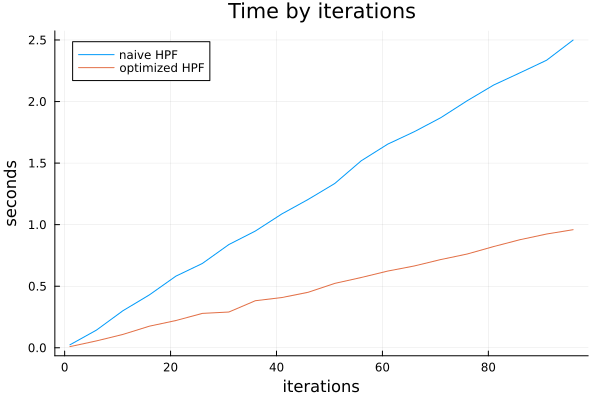

In [21]:
# Measure time vs number of iterations

speed_test_cases = 1:5:100

Random.seed!(SEED)
optimized_time = []
for iters in speed_test_cases
    stats = @timed train_hpf_mcmc(hpf_optimized, known_interaction_matrix, default_params, iters, all_interaction_matrix)
    push!(optimized_time, stats.time)
end

Random.seed!(SEED)
naive_time = []
for iters in speed_test_cases
    stats = @timed train_hpf_mcmc(hpf_naive, known_interaction_matrix, default_params, iters, all_interaction_matrix)
    push!(naive_time, stats.time)
end

plot(speed_test_cases, [naive_time, optimized_time], labels=["naive HPF" "optimized HPF"], xlabel="iterations", ylabel="seconds", title="Time by iterations")

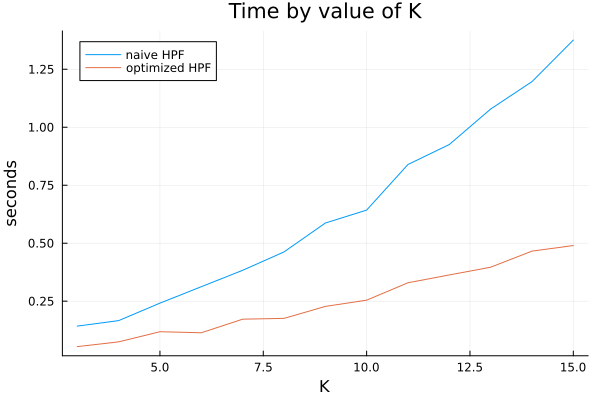

In [22]:
# Measure time vs size of K

speed_test_cases = 3:1:15

Random.seed!(SEED)
optimized_time = []
for K in speed_test_cases
    params = copy(default_params)
    params[:K] = K
    stats = @timed train_hpf_mcmc(hpf_optimized, known_interaction_matrix, params, 25, all_interaction_matrix)
    push!(optimized_time, stats.time)
end

Random.seed!(SEED)
naive_time = []
for K in speed_test_cases
    params = copy(default_params)
    params[:K] = K
    stats = @timed train_hpf_mcmc(hpf_naive, known_interaction_matrix, params, 25, all_interaction_matrix)
    push!(naive_time, stats.time)
end

plot(speed_test_cases, [naive_time, optimized_time], labels=["naive HPF" "optimized HPF"], xlabel="K", ylabel="seconds", title="Time by value of K")

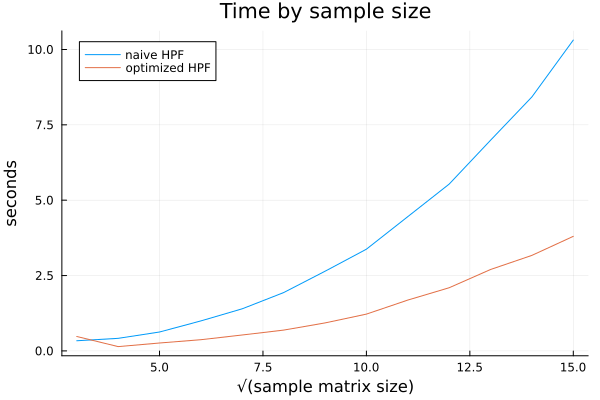

In [23]:
# Measure time vs sample size

speed_test_cases = 3:1:15

Random.seed!(SEED)
optimized_time = []
for n in speed_test_cases
    sample_matrix = rand([0, 1], n, n)
    stats = @timed train_hpf_mcmc(hpf_optimized, sample_matrix, default_params, 25, all_interaction_matrix)
    push!(optimized_time, stats.time)
end

Random.seed!(SEED)
naive_time = []
for n in speed_test_cases
    sample_matrix = rand([0, 1], n, n)
    stats = @timed train_hpf_mcmc(hpf_naive, sample_matrix, default_params, 25, all_interaction_matrix)
    push!(naive_time, stats.time)
end

plot(speed_test_cases, [naive_time, optimized_time], labels=["naive HPF" "optimized HPF"], xlabel="√(sample matrix size)", ylabel="seconds", title="Time by sample size")

### Training the optimized model

  5.100869 seconds (62.15 M allocations: 2.842 GiB, 7.61% gc time)


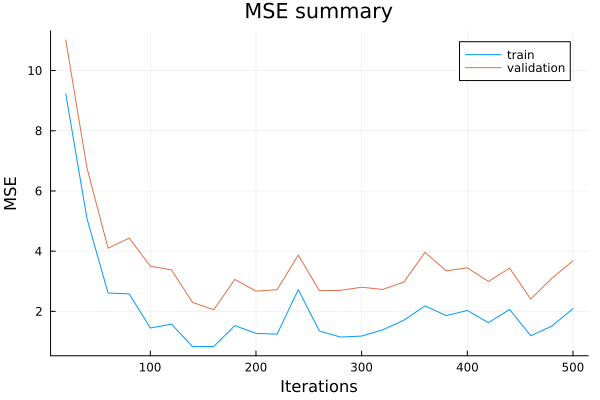

In [24]:
Random.seed!(SEED)
train_iters = 500
predict_samples = 50
thin = 3

status_every = 20
statuf_of_n = 15

trained_hpf_trace, train_mse_results, validation_mse_results = @time train_hpf_mcmc(
    hpf_optimized,
    known_interaction_matrix, 
    default_params, 
    train_iters, 
    all_interaction_matrix, 
    status_every, 
    statuf_of_n
)

plot(status_every:status_every:(length(train_mse_results) * status_every), [train_mse_results, validation_mse_results], xlabel="Iterations", ylabel="MSE", label=["train" "validation"], title="MSE summary")

## Evaluating HPF vs Random on a small random sample

In [25]:
function evaluate_hpf(trace, params, train_set, validation_set, n_prediction_samples, n_thin)
    n, m = size(train_set)
    
    # true and no prediction
    true_prediction_MSE = mse(validation_set, validation_set)
    no_prediction_MSE = mse(validation_set, train_set)
    
    # predict train + validation
    random_train_validation = random_predict(train_set, Random.Xoshiro(SEED), true)
    random_train_validation_MSE = mse(validation_set, random_train_validation)
    
    Random.seed!(SEED)
    hpf_train_validation = compute_hpf_mean_y(trace, params[:K], n, m, n_prediction_samples, n_thin)
    hpf_train_validation_MSE = mse(validation_set, hpf_train_validation)
    
    # preload train, predict validation set
    random_preload_train_validation = random_predict(train_set, Random.Xoshiro(SEED), false)
    random_preload_train_validation_MSE = mse(validation_set, random_preload_train_validation)

    Random.seed!(SEED)
    hpf_preload_train_validation = predict_hpf(trace, params[:K], train_set, n_prediction_samples, n_thin)
    hpf_preload_train_validation_MSE = mse(validation_set, hpf_preload_train_validation)    
    
    return DataFrame(
        :model => [
            "True", 
            "No prediction",

            "Random (predict train + validation)", 
            "HPF (predict train + validation)",

            "Random (preload train, predict validation set)",
            "HPF (preload train, predict validation set)", 
        ],

        :MSE => [
            true_prediction_MSE, 
            no_prediction_MSE, 
            
            random_train_validation_MSE,
            hpf_train_validation_MSE,
            
            random_preload_train_validation_MSE,
            hpf_preload_train_validation_MSE,
        ]
    )
end

evaluate_hpf(trained_hpf_trace, default_params, known_interaction_matrix, all_interaction_matrix, predict_samples, thin)

Row,model,MSE
,String,Float64
1,True,0.0
2,No prediction,2.36
3,Random (predict train + validation),9.76
4,HPF (predict train + validation),2.72227
5,"Random (preload train, predict validation set)",2.0
6,"HPF (preload train, predict validation set)",1.51194


## Appendix: Julia dependencies

In [26]:
using Pkg

Pkg.add("PyCall")
Pkg.add("Gen")
Pkg.add("Pipe")
Pkg.add("StatsBase")
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("DataFramesMeta")

    Updating registry at `C:\Users\mferaru\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\mferaru\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\mferaru\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\mferaru\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\mferaru\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\mferaru\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\mferaru\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\mferaru\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\mferaru\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\mferaru\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\mferaru\.julia\environments\v1.8\Manifest.toml`
   Resolving package vers